In [2]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import torchvision.models as models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

# Replace with your directory path
tar_path = '/content/drive/MyDrive/Colab Notebooks/Vision/mvtec_anomaly_detection.tar.xz'
extract_path = '/content/drive/MyDrive/Colab Notebooks/Vision/mvtec_anomaly_detection/'

In [5]:
import tarfile

# Open tar file
with tarfile.open(tar_path, 'r') as tar:
    tar.extractall(path=extract_path)

print(f'Files have been extracted to {extract_path}')


Files have been extracted to /content/drive/MyDrive/Colab Notebooks/Vision/mvtec_anomaly_detection/


In [6]:
# List files in the extracted directory
extracted_files = os.listdir(extract_path)
print(extracted_files)

['toothbrush', 'wood', 'transistor', 'zipper', 'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'readme.txt', 'license.txt']


In [7]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to extracted files
data_dir = '/content/drive/MyDrive/Colab Notebooks/Vision/mvtec_anomaly_detection/'

# Display a sample image from the dataset
categories = os.listdir(data_dir)
for category in categories:
    path = os.path.join(data_dir, category)

    # Check if the path is a directory
    if not os.path.isdir(path):
        continue

    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_array = cv2.imread(img_path)

        # Check if the image was loaded correctly
        if img_array is None:
            print(f"Failed to load image: {img_path}")
            continue

        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

Failed to load image: /content/drive/MyDrive/Colab Notebooks/Vision/mvtec_anomaly_detection/toothbrush/license.txt
Failed to load image: /content/drive/MyDrive/Colab Notebooks/Vision/mvtec_anomaly_detection/toothbrush/readme.txt
Failed to load image: /content/drive/MyDrive/Colab Notebooks/Vision/mvtec_anomaly_detection/toothbrush/ground_truth
Failed to load image: /content/drive/MyDrive/Colab Notebooks/Vision/mvtec_anomaly_detection/toothbrush/train
Failed to load image: /content/drive/MyDrive/Colab Notebooks/Vision/mvtec_anomaly_detection/toothbrush/test


Setting Random Seeds


In [8]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# **Transforms**
Defines a series of image transformations for data augmentation to increase the robustness of the model.



In [9]:
# Path to extracted files
data_dir = '/content/drive/MyDrive/Colab Notebooks/Vision/mvtec_anomaly_detection/'

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **Load and preprocess data**

MVTecDataset class is essential for preparing the data in a format suitable for training and validating a machine learning model in PyTorch. It handles the loading, preprocessing, and augmentation of images, ensuring they are ready for input into the neural network.

**'__init_' :** Initializes the dataset by setting up the directory path, transformation, and lists to hold image paths, labels, and categories.

**_add_category_images:** Adds images from a specific category to the dataset.Adds normal images from the train/good directory with label 0. Adds anomalous images from the test directory with label 1.

**'__len_':** Returns the total number of images in the dataset.

**'__getitem_:** Retrieves an image and its label based on an index. Reads the image from the stored path using OpenCV. then converts the image from BGR to RGB format. Applies the specified transformations. Returns the transformed image, its label, and its category



In [10]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.categories = []

        for category in os.listdir(root_dir):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                self._add_category_images(category_path, category)

    def _add_category_images(self, category_path, category):
        # Add normal images
        normal_dir = os.path.join(category_path, 'train', 'good')
        if os.path.isdir(normal_dir):
            for img_name in os.listdir(normal_dir):
                img_path = os.path.join(normal_dir, img_name)
                self.images.append(img_path)
                self.labels.append(0)  # 0 for normal
                self.categories.append(category)

        # Add anomalous images
        test_dir = os.path.join(category_path, 'test')
        if os.path.isdir(test_dir):
            for condition in os.listdir(test_dir):
                if condition != 'good':
                    condition_dir = os.path.join(test_dir, condition)
                    if os.path.isdir(condition_dir):
                        for img_name in os.listdir(condition_dir):
                            img_path = os.path.join(condition_dir, img_name)
                            self.images.append(img_path)
                            self.labels.append(1)  # 1 for anomaly
                            self.categories.append(category)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx], self.categories[idx]


# **Dataset and DataLoader Creation**
Creates the dataset and splits it into training and validation sets, then creates data loaders for batch processing.



In [11]:
# Create dataset
full_dataset = MVTecDataset(data_dir, transform=transform)

# Split dataset
train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.2, stratify=full_dataset.labels, random_state=42)
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **CNN Model Definition**
Defines the CNN model based on a pre-trained ResNet-18 with a modified final layer for binary classification.

# **Why Use CNNs for This Problem?**

**CNNs for Image Classification**


*   **Local Connectivity:** CNNs use filters that can capture local patterns such as edges, textures, and shapes, which are critical for understanding image content.
*   **Parameter Sharing:** Filters are shared across the entire image, reducing the number of parameters and computation required, making the model more efficient and effective.
*   **Spatial Hierarchies:** CNNs can learn spatial hierarchies of features, meaning they can understand complex structures by combining simpler features detected in earlier layers.

**Anomaly Detection**


*   **Feature Extraction:** CNNs are excellent at automatically learning and extracting relevant features from images, which is crucial for distinguishing between normal and anomalous patterns.
*   **Scalability:** CNNs can handle large image datasets and complex patterns, which are common in anomaly detection tasks.


# **Why Use ResNet?**

**Residual Networks (ResNet)**


*   **Deeper Networks:** ResNet allows the training of very deep networks by using residual connections, which help in mitigating the vanishing gradient problem. This is essential as deeper networks generally perform better in extracting complex features.
*   **Proven Performance:** ResNet architectures have consistently shown good performance in many image classification tasks, making them a reliable choice.












In [12]:
# Define the CNN model
class AnomalyDetectionModel(nn.Module):
    def __init__(self):
        super(AnomalyDetectionModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification

    def forward(self, x):
        return self.model(x)

# **Loss Function and Optimizer**
Defines the loss function (cross-entropy with class weights) and the optimizer (Adam with a small learning rate).

# **Training Loop**

Defines the training and validation loops for 10 epochs, computing and printing the loss and accuracy for each epoch.




In [13]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnomalyDetectionModel().to(device)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(full_dataset.labels), y=full_dataset.labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Smaller learning rate

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%')

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_scores = []
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs[:, 1].cpu().numpy())  # Use the score for the anomaly class

    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'cnn_anomaly_detection.pth')

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current 

Epoch [1/10], Loss: 0.5872, Accuracy: 67.18%
Validation Loss: 0.5137, Validation Accuracy: 78.02%
Epoch [2/10], Loss: 0.4563, Accuracy: 78.38%
Validation Loss: 0.4751, Validation Accuracy: 79.55%
Epoch [3/10], Loss: 0.4112, Accuracy: 79.84%
Validation Loss: 0.3884, Validation Accuracy: 84.56%
Epoch [4/10], Loss: 0.3610, Accuracy: 83.91%
Validation Loss: 0.4435, Validation Accuracy: 83.74%
Epoch [5/10], Loss: 0.3303, Accuracy: 84.52%
Validation Loss: 0.3621, Validation Accuracy: 83.84%
Epoch [6/10], Loss: 0.3179, Accuracy: 86.88%
Validation Loss: 0.3395, Validation Accuracy: 87.73%
Epoch [7/10], Loss: 0.2892, Accuracy: 87.36%
Validation Loss: 0.4749, Validation Accuracy: 84.97%
Epoch [8/10], Loss: 0.2491, Accuracy: 89.49%
Validation Loss: 0.2959, Validation Accuracy: 85.28%
Epoch [9/10], Loss: 0.2544, Accuracy: 89.77%
Validation Loss: 0.3276, Validation Accuracy: 86.40%
Epoch [10/10], Loss: 0.2570, Accuracy: 89.61%
Validation Loss: 0.3142, Validation Accuracy: 85.48%


# **Loss and Accuracy**

*   The model starts with a moderate training loss and accuracy, indicating it is learning but still has much room for improvement.
*   The training loss consistently decreases, suggesting that the model is improving in fitting the training data.
*   The accuracy increases steadily, indicating that the model is getting better at correctly predicting the labels of the training data.

The results indicate a well-performing model with good generalization to the validation set. The decreasing training loss and increasing accuracy, along with stable validation performance, show that the model is effectively learning to distinguish between normal and anomalous images.

The minor fluctuations in validation loss and accuracy are typical and suggest that while the model is learning, it is also adapting to the complexities of the validation data.






# **ROC and AUC Curve**

The ROC (Receiver Operating Characteristic) curve and the high AUC (Area Under the Curve) value of 0.94 demonstrate that the anomaly detection model performs well. It is highly effective at distinguishing between normal and anomalous images, with a high rate of correctly identified anomalies and a low rate of false alarms.

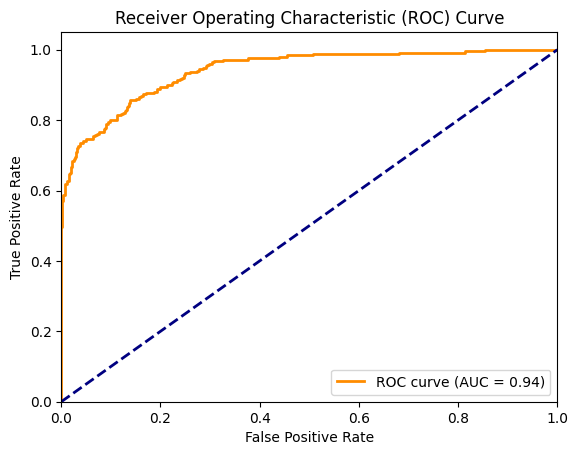

In [15]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **Confusion Martix**

*   Rows represent the actual classes (True labels).
*   Columns represent the predicted classes (Predicted labels).

The confusion matrix indicates that the model is performing well, with high accuracy, precision, and recall. However, the false negatives suggest that there might be a need to improve the model's sensitivity to anomalies.










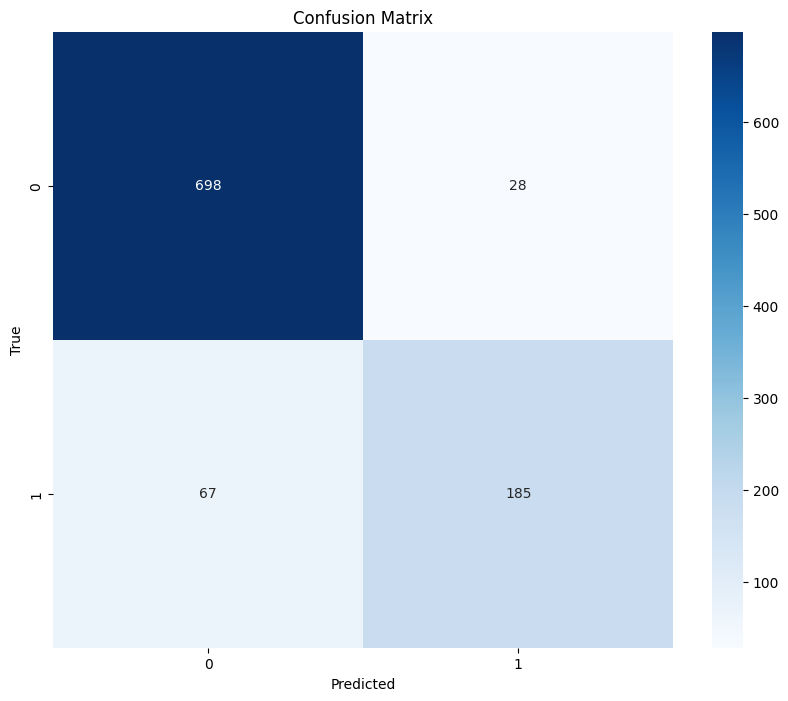

In [16]:
# Compute confusion matrix
y_pred = (np.array(y_scores) > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# **Classification Report**


*   **Accuracy: 0.90:** The model correctly predicts the class of 90% of the images.

*   **Precision: 0.90:** Takes into account the precision of each class, weighted by the number of true instances for each class.
*   **Recall: 0.90:** Takes into account the recall of each class, weighted by the number of true instances for each class.
*   **F1-Score: 0.90:** Takes into account the F1-score of each class, weighted by the number of true instances for each class.








In [17]:
# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       726
           1       0.87      0.73      0.80       252

    accuracy                           0.90       978
   macro avg       0.89      0.85      0.87       978
weighted avg       0.90      0.90      0.90       978



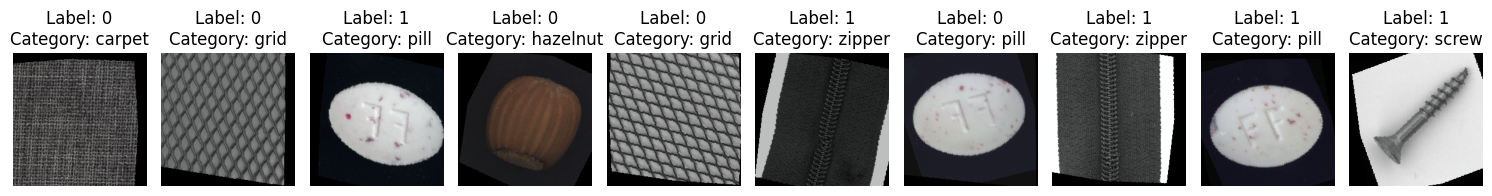

In [18]:
import random
import matplotlib.pyplot as plt

def inspect_dataset(dataset, num_samples=10):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))

    for i, idx in enumerate(indices):
        image, label, category = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        axes[i].imshow(image.astype(np.uint8))
        axes[i].set_title(f'Label: {label}\nCategory: {category}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Inspect a random sample of images from the training dataset
inspect_dataset(full_dataset, num_samples=10)


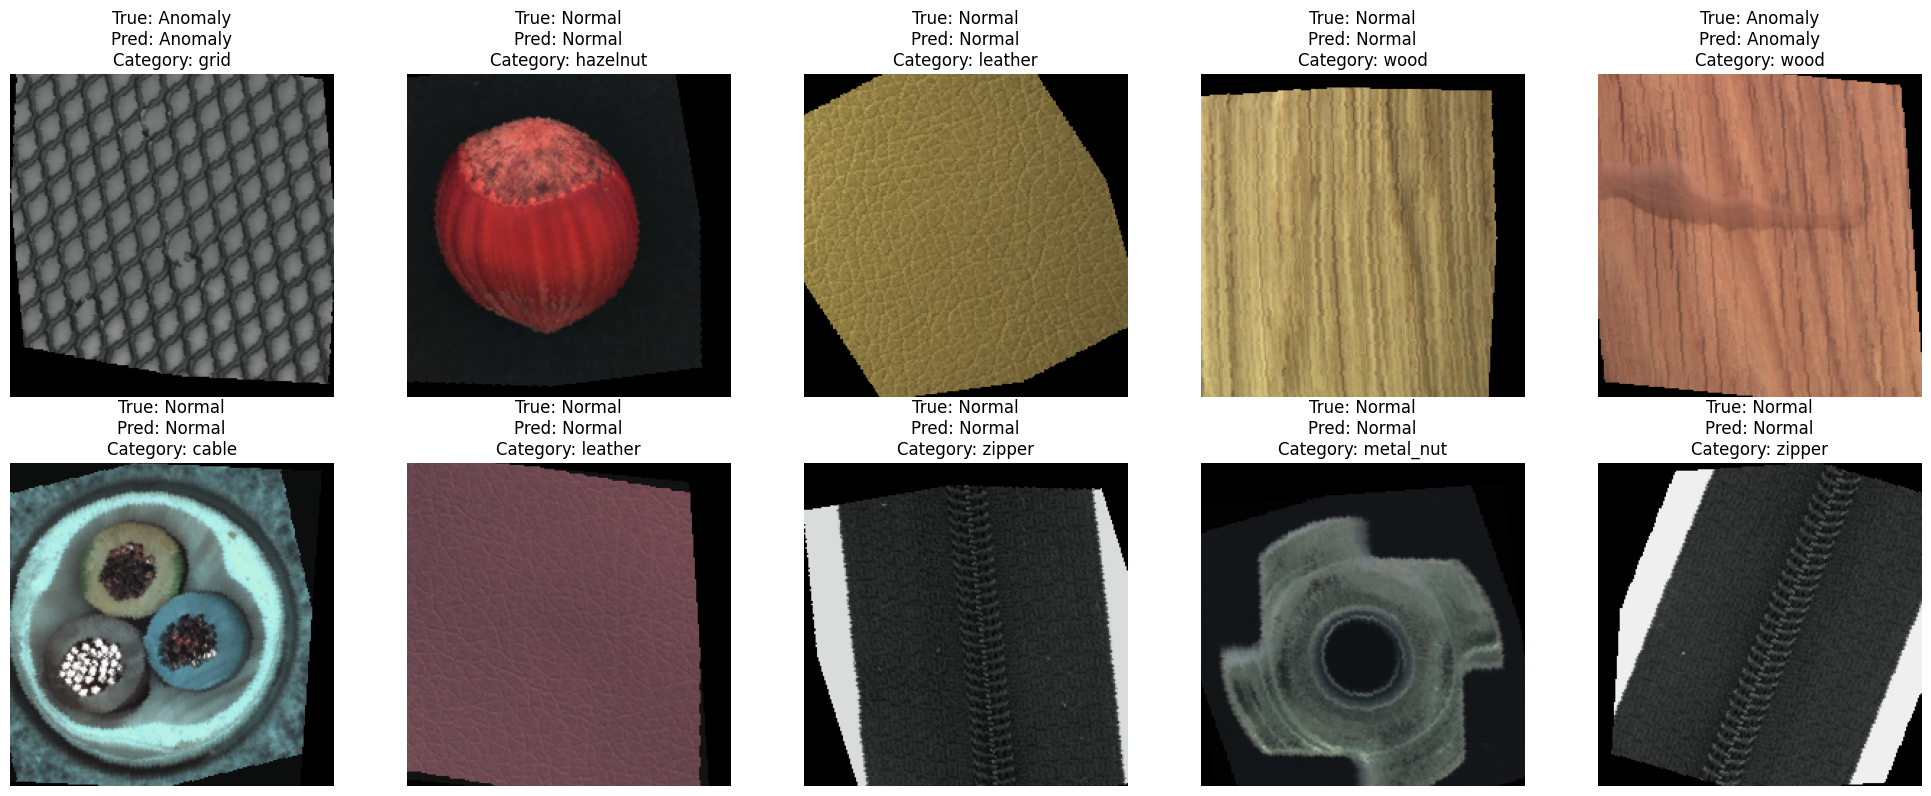

In [20]:
# Function to visualize correctly classified images
def visualize_correctly_classified(model, val_loader, num_images=10):
    model.eval()
    correctly_classified = []
    with torch.no_grad():
        for images, labels, categories in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            for i in range(len(images)):
                if predicted[i] == labels[i]:
                    correctly_classified.append((images[i], labels[i], predicted[i], categories[i]))
                if len(correctly_classified) >= num_images:
                    break
            if len(correctly_classified) >= num_images:
                break

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i, (image, true_label, pred_label, category) in enumerate(correctly_classified[:num_images]):
        image = image.cpu().permute(1, 2, 0).numpy()
        image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        ax = axes[i // 5, i % 5]
        ax.imshow(image.astype(np.uint8))
        ax.set_title(f"True: {'Normal' if true_label == 0 else 'Anomaly'}\nPred: {'Normal' if pred_label == 0 else 'Anomaly'}\nCategory: {category}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize correctly classified images
visualize_correctly_classified(model, val_loader)

The provided output displays the accuracy of the anomaly detection model across different categories.

Each category represents a specific type of object or item, and the accuracy indicates how well the model performs in identifying normal and anomalous instances within each category.

In [21]:
# Analyze performance by category
category_performance = {}
model.eval()
with torch.no_grad():
    for images, labels, categories in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        for category, true_label, pred_label in zip(categories, labels, predicted):
            if category not in category_performance:
                category_performance[category] = {"correct": 0, "total": 0}
            category_performance[category]["total"] += 1
            if true_label == pred_label:
                category_performance[category]["correct"] += 1

for category, performance in category_performance.items():
    accuracy = performance["correct"] / performance["total"]
    print(f"Category: {category}, Accuracy: {accuracy:.4f}")

Category: grid, Accuracy: 0.9559
Category: capsule, Accuracy: 0.4286
Category: hazelnut, Accuracy: 0.9750
Category: leather, Accuracy: 1.0000
Category: wood, Accuracy: 1.0000
Category: cable, Accuracy: 0.7838
Category: zipper, Accuracy: 0.9610
Category: metal_nut, Accuracy: 0.8594
Category: bottle, Accuracy: 0.9808
Category: screw, Accuracy: 0.7159
Category: tile, Accuracy: 0.9605
Category: carpet, Accuracy: 1.0000
Category: toothbrush, Accuracy: 0.6190
Category: pill, Accuracy: 0.7683
Category: transistor, Accuracy: 0.9000
